Please keep in mind that both the training and testing datasets are very large.

Running any model takes over an hour.

So run the models only if you have the time.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports
===

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
# from keras.engine.topology import Merge
# from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import TimeDistributed, Lambda
from keras.layers import Convolution1D, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text
from keras import Model
from keras.layers import Dense, Input, LSTM, Embedding
import _pickle
!pip install fuzzywuzzy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Paths
===

In [ ]:
cnnModelPreds = "/content/drive/My Drive/MLPW/CNNmainpreds.csv"
gloveEmbdeddingMatrixPath ="/content/drive/My Drive/MLPW/glove_embeddings.pkl"
trainDatasetPath = "/content/drive/My Drive/MLPW/mostly_processed.csv"
logisticRegressionPath = '/content/drive/My Drive/MLPW/logisticPreds.csv'
googleNewsVectorsHostedPath = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
convModelWeights = '/content/drive/My Drive/MLPW/weightsConv.h5'
testDatasetPath = '/content/drive/My Drive/MLPW/test.csv'
testProcessedPath = '/content/drive/My Drive/MLPW/test_processed.csv'
lstmconvdistWeights = '/content/drive/My Drive/MLPW/lstmconvdistWeights.h5'
lstmconvdistPreds = '/content/drive/My Drive/MLPW/lstmconvdistpreds.csv'
lstmconvdistnostopwordsWeights = '/content/drive/My Drive/MLPW/lstmconvdistnostopwordsWeights.h5'
lstmconvdistnostopwordsPreds = '/content/drive/My Drive/MLPW/lstmconvdistpredsnostopwords.csv'


Dataset
===

In [ ]:
data = pd.read_csv(trainDatasetPath, encoding='utf8',index_col = 0)
embedding_matrix = _pickle.load(open(gloveEmbdeddingMatrixPath,'rb'))
y = data["is_duplicate"].values
ytrain_enc = np_utils.to_categorical(y)
y_train = np.asarray(ytrain_enc).astype('float32').reshape((-1,1))
distance_columns = ['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'jaccard_distance',
       'canberra_distance', 'euclidean_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'kur_q2vec']

# Logisitc + PCA

In [ ]:
  ### PCA from scratch

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import numpy as np
def scaler(matrix):
    #work on each row of the matrix
    scaler = StandardScaler()
    scaler.fit(matrix)
    scaled_matrix = scaler.transform(matrix)
    return scaled_matrix
        
def PCA(matrix,n):
    '''
    takes in numpy matrix and returns the reduced version of it to n dimensions
    n should be less than the original number of columns
    '''
    # scale the data
    scaled_matrix = scaler(matrix)
    # take the covariance of the scaled_matrix
    cov_matrix = scaled_matrix.T.dot(scaled_matrix)
    # get the eigen vectors and the eigen values
    eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)
    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = np.flip(idx_sorted)

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,:2]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.T,scaled_matrix.T).T
    return X_reduced

from numpy import log, dot, e
from numpy.random import rand

class LogisticRegression:
    def __init__(self):
      self.weights = None
      self.loss = None
    def sigmoid(self, z): 
      return 1 / (1 + e**(-z))

    def cost_function(self, X, y, weights):                 
      z = dot(X, weights)
      predict_1 = y * log(self.sigmoid(z))
      predict_0 = (1 - y) * log(1 - self.sigmoid(z))
      return -sum(predict_1 + predict_0) / len(X)

    def fit(self, X, y, epochs=25, lr=0.05):        
      loss = []
      weights = rand(X.shape[1])
      N = len(X)
                
      for _ in range(epochs):        
        # Gradient Descent
        y_hat = self.sigmoid(dot(X, weights))
        weights -= lr * dot(X.T,  y_hat - y) / N            
        # Saving Progress
        loss.append(self.cost_function(X, y, weights)) 
          
      self.weights = weights
      self.loss = loss

    def predict(self, X):        
      # Predicting with sigmoid function
      z = dot(X, self.weights)
      # Returning binary result
      return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]

  stop_words = stopwords.words('english')

  def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
      try:
        M.append(model[w])
      except:
        continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())
safe = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2',
       'len_word_q1', 'len_word_q2', 'common_words', 'fuzz_qratio',
       'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_token_sort_ratio', 'cityblock_distance', 'jaccard_distance',
       'canberra_distance', 'euclidean_distance', 'minkowski_distance',
       'skew_q1vec', 'skew_q2vec', 'kur_q1vec', 'kur_q2vec']

def batch_pred_logistic(data):
    data['len_q1'] = data.question1.apply(lambda x: len(str(x)))
    data['len_q2'] = data.question2.apply(lambda x: len(str(x)))
    data['diff_len'] = data.len_q1 - data.len_q2
    data['len_char_q1'] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    data['len_char_q2'] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    data['len_word_q1'] = data.question1.apply(lambda x: len(str(x).split()))
    data['len_word_q2'] = data.question2.apply(lambda x: len(str(x).split()))
    data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    question1_vectors = np.zeros((data.shape[0], 300))
    for i, q in tqdm(enumerate(data.question1.values)):
        question1_vectors[i, :] = sent2vec(q)
    question2_vectors  = np.zeros((data.shape[0], 300))
    for i, q in tqdm(enumerate(data.question2.values)):
        question2_vectors[i, :] = sent2vec(q)
    data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                          np.nan_to_num(question2_vectors))]
    data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
    data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
    data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
    data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]
    matrix = PCA(data[safe].to_numpy(),2)
    df = pd.DataFrame()
    df['test_id'] = data['test_id']
    df['is_duplicate'] = model.predict(matrix)
    return df


In [ ]:
matrix = PCA(data[safe].to_numpy(dtype = float),2)
df_pcad = pd.DataFrame()
df_pcad['pca1'] = matrix[:,0]
df_pcad['pca2'] = matrix[:,1]
df_pcad['is_duplicate'] = data['is_duplicate']

model = LogisticRegression()
model.fit(matrix, df_pcad['is_duplicate'].to_numpy(), epochs = 1000)
import time
submission = pd.DataFrame(columns = ['test_id','is_duplicate'])
test_iterator = pd.read_csv(testDatasetPath, chunksize = 5000)
i = 0
global_start_time = time.time()
time_per_chunk = []
for chunk in test_iterator:
    # print(type(chunk))
    i = i+1
    loop_start_time = time.time()
    dfapp = batch_pred_logistic(chunk)
    loop_time = (time.time() - loop_start_time)
    time_per_chunk.append(loop_time)
    print("chunk ",i," execution_time ",loop_time)
    submission = submission.append(dfapp)
global_train_time = time.time() - global_start_time 
print("total train time ", global_train_time)
# submission.to_csv(logisticPredictionPath)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6535.81it/s]
5000it [00:00, 6244.76it/s]


chunk  1  execution_time  46.2850124835968


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6751.52it/s]
5000it [00:00, 6705.63it/s]


chunk  2  execution_time  45.269978523254395


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6665.14it/s]
5000it [00:00, 6737.05it/s]


chunk  3  execution_time  45.12807559967041


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6584.54it/s]
5000it [00:00, 6365.93it/s]


chunk  4  execution_time  46.96396088600159


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6672.33it/s]
5000it [00:00, 6402.58it/s]


chunk  5  execution_time  46.153541803359985


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6571.89it/s]
5000it [00:00, 6756.00it/s]


chunk  6  execution_time  45.707496881484985


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6717.61it/s]
5000it [00:00, 6571.27it/s]


chunk  7  execution_time  47.12289214134216


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6730.59it/s]
5000it [00:00, 6603.96it/s]


chunk  8  execution_time  46.574331521987915


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6689.92it/s]
5000it [00:00, 6650.55it/s]


chunk  9  execution_time  45.903969526290894


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6561.07it/s]
5000it [00:00, 6427.40it/s]


chunk  10  execution_time  45.598599672317505


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6539.11it/s]
5000it [00:00, 6590.61it/s]


chunk  11  execution_time  45.774378538131714


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6689.56it/s]
5000it [00:00, 6510.28it/s]


chunk  12  execution_time  46.575507402420044


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6675.00it/s]
5000it [00:00, 6723.10it/s]


chunk  13  execution_time  47.333508014678955


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6682.01it/s]
5000it [00:00, 6728.19it/s]


chunk  14  execution_time  44.96168375015259


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6568.36it/s]
5000it [00:00, 6749.22it/s]


chunk  15  execution_time  46.06763315200806


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6586.80it/s]
5000it [00:00, 6356.24it/s]


chunk  16  execution_time  47.16127967834473


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6401.61it/s]
5000it [00:00, 6810.11it/s]


chunk  17  execution_time  46.7076621055603


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6428.82it/s]
5000it [00:00, 6479.45it/s]


chunk  18  execution_time  46.31514239311218


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6555.13it/s]
5000it [00:00, 6642.44it/s]


chunk  19  execution_time  45.08453106880188


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6554.82it/s]
5000it [00:00, 6653.57it/s]


chunk  20  execution_time  47.040939807891846


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6603.17it/s]
5000it [00:00, 6614.04it/s]


chunk  21  execution_time  46.5108802318573


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6717.38it/s]
5000it [00:00, 6437.95it/s]


chunk  22  execution_time  45.49729633331299


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6637.06it/s]
5000it [00:00, 6783.59it/s]


chunk  23  execution_time  45.71877908706665


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6673.82it/s]
5000it [00:00, 6685.30it/s]


chunk  24  execution_time  46.09220623970032


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6431.71it/s]
5000it [00:00, 6594.78it/s]


chunk  25  execution_time  46.81988310813904


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6739.29it/s]
5000it [00:00, 6669.66it/s]


chunk  26  execution_time  46.001121520996094


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6702.45it/s]
5000it [00:00, 6552.82it/s]


chunk  27  execution_time  45.95640158653259


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6596.85it/s]
5000it [00:00, 6531.94it/s]


chunk  28  execution_time  45.54279708862305


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6792.86it/s]
5000it [00:00, 6466.47it/s]


chunk  29  execution_time  45.93473172187805


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6479.50it/s]
5000it [00:00, 6698.27it/s]


chunk  30  execution_time  45.6590051651001


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6839.08it/s]
5000it [00:00, 6839.74it/s]


chunk  31  execution_time  45.52132868766785


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6588.40it/s]
5000it [00:00, 6622.22it/s]


chunk  32  execution_time  45.3048095703125


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6656.43it/s]
5000it [00:00, 6622.09it/s]


chunk  33  execution_time  46.85358762741089


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6724.45it/s]
5000it [00:00, 6604.02it/s]


chunk  34  execution_time  46.740158796310425


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6452.83it/s]
5000it [00:00, 6717.19it/s]


chunk  35  execution_time  47.04929566383362


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6545.01it/s]
5000it [00:00, 6869.26it/s]


chunk  36  execution_time  45.97977900505066


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6646.44it/s]
5000it [00:00, 6782.04it/s]


chunk  37  execution_time  46.06478524208069


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6513.66it/s]
5000it [00:00, 6962.81it/s]


chunk  38  execution_time  46.1927011013031


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6742.98it/s]
5000it [00:00, 6776.65it/s]


chunk  39  execution_time  46.57050347328186


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6793.84it/s]
5000it [00:00, 6670.86it/s]


chunk  40  execution_time  46.693620920181274


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6800.56it/s]
5000it [00:00, 6751.63it/s]


chunk  41  execution_time  46.03510570526123


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6619.19it/s]
5000it [00:00, 6868.10it/s]


chunk  42  execution_time  45.704983949661255


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6718.16it/s]
5000it [00:00, 6755.77it/s]


chunk  43  execution_time  45.8292760848999


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6753.81it/s]
5000it [00:00, 6758.88it/s]


chunk  44  execution_time  46.37445521354675


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6808.96it/s]
5000it [00:00, 6741.73it/s]


chunk  45  execution_time  46.11364507675171


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6687.24it/s]
5000it [00:00, 6626.15it/s]


chunk  46  execution_time  45.22578287124634


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6741.80it/s]
5000it [00:00, 6812.09it/s]


chunk  47  execution_time  45.39743447303772


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6721.41it/s]
5000it [00:00, 6776.71it/s]


chunk  48  execution_time  45.56599473953247


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6937.35it/s]
5000it [00:00, 6601.63it/s]


chunk  49  execution_time  46.26817536354065


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6799.91it/s]
5000it [00:00, 6650.65it/s]


chunk  50  execution_time  44.93521761894226


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6950.16it/s]
5000it [00:00, 6575.22it/s]


chunk  51  execution_time  46.16097044944763


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6917.39it/s]
5000it [00:00, 6781.06it/s]


chunk  52  execution_time  45.45875120162964


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6782.93it/s]
5000it [00:00, 6420.39it/s]


chunk  53  execution_time  44.804145097732544


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6816.17it/s]
5000it [00:00, 6625.80it/s]


chunk  54  execution_time  44.932464599609375


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6834.86it/s]
5000it [00:00, 6113.65it/s]


chunk  55  execution_time  46.81830716133118


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6674.39it/s]
5000it [00:00, 6722.51it/s]


chunk  56  execution_time  45.338690757751465


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6734.45it/s]
5000it [00:00, 6643.68it/s]


chunk  57  execution_time  46.30628848075867


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6857.57it/s]
5000it [00:00, 6588.09it/s]


chunk  58  execution_time  46.21419715881348


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6859.41it/s]
5000it [00:00, 6659.30it/s]


chunk  59  execution_time  46.73621392250061


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6527.32it/s]
5000it [00:00, 6620.19it/s]


chunk  60  execution_time  47.144325256347656


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6520.29it/s]
5000it [00:00, 6666.08it/s]


chunk  61  execution_time  44.51062083244324


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6459.32it/s]
5000it [00:00, 6681.07it/s]


chunk  62  execution_time  45.28346014022827


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6676.95it/s]
5000it [00:00, 6706.25it/s]


chunk  63  execution_time  46.918062925338745


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6688.08it/s]
5000it [00:00, 6753.78it/s]


chunk  64  execution_time  45.92008399963379


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6811.67it/s]
5000it [00:00, 6758.79it/s]


chunk  65  execution_time  44.997376680374146


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6865.74it/s]
5000it [00:00, 6780.59it/s]


chunk  66  execution_time  45.572386741638184


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6684.03it/s]
5000it [00:00, 6374.84it/s]


chunk  67  execution_time  46.55976748466492


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6831.01it/s]
5000it [00:00, 6659.26it/s]


chunk  68  execution_time  45.22137117385864


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6745.95it/s]
5000it [00:00, 6714.74it/s]


chunk  69  execution_time  46.40580487251282


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6833.57it/s]
5000it [00:00, 6700.41it/s]


chunk  70  execution_time  45.86294913291931


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6804.81it/s]
5000it [00:00, 6677.37it/s]


chunk  71  execution_time  45.9568772315979


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6729.17it/s]
5000it [00:00, 6599.62it/s]


chunk  72  execution_time  46.56366276741028


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6693.00it/s]
5000it [00:00, 6752.41it/s]


chunk  73  execution_time  46.297648906707764


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6595.83it/s]
5000it [00:00, 6542.96it/s]


chunk  74  execution_time  45.680912494659424


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6910.93it/s]
5000it [00:00, 6734.35it/s]


chunk  75  execution_time  44.95124673843384


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6682.61it/s]
5000it [00:00, 6586.35it/s]


chunk  76  execution_time  46.454673767089844


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6898.04it/s]
5000it [00:00, 6660.06it/s]


chunk  77  execution_time  45.449583768844604


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6726.44it/s]
5000it [00:00, 6708.37it/s]


chunk  78  execution_time  44.63814187049866


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6946.84it/s]
5000it [00:00, 6839.64it/s]


chunk  79  execution_time  45.00880026817322


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6759.81it/s]
5000it [00:00, 6933.84it/s]


chunk  80  execution_time  45.263322830200195


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7000.96it/s]
5000it [00:00, 6855.82it/s]


chunk  81  execution_time  43.83353090286255


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6941.85it/s]
5000it [00:00, 6702.52it/s]


chunk  82  execution_time  43.807135820388794


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6989.88it/s]
5000it [00:00, 6774.39it/s]


chunk  83  execution_time  44.81348729133606


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7069.53it/s]
5000it [00:00, 6911.09it/s]


chunk  84  execution_time  44.275672912597656


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6888.71it/s]
5000it [00:00, 6789.54it/s]


chunk  85  execution_time  44.931199073791504


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6721.08it/s]
5000it [00:00, 6860.76it/s]


chunk  86  execution_time  43.420660972595215


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6912.82it/s]
5000it [00:00, 6974.49it/s]


chunk  87  execution_time  43.99710440635681


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6898.74it/s]
5000it [00:00, 6900.18it/s]


chunk  88  execution_time  45.23455357551575


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6774.61it/s]
5000it [00:00, 6779.68it/s]


chunk  89  execution_time  44.9003050327301


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6919.50it/s]
5000it [00:00, 6893.77it/s]


chunk  90  execution_time  45.2093448638916


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6972.24it/s]
5000it [00:00, 6937.86it/s]


chunk  91  execution_time  44.559324979782104


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6833.75it/s]
5000it [00:00, 6707.20it/s]


chunk  92  execution_time  45.48119115829468


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6990.54it/s]
5000it [00:00, 6646.00it/s]


chunk  93  execution_time  45.09595084190369


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6950.08it/s]
5000it [00:00, 6932.43it/s]


chunk  94  execution_time  44.823282957077026


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6950.41it/s]
5000it [00:00, 6767.92it/s]


chunk  95  execution_time  45.35170006752014


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6891.13it/s]
5000it [00:00, 6683.46it/s]


chunk  96  execution_time  45.61856508255005


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6924.63it/s]
5000it [00:00, 6883.79it/s]


chunk  97  execution_time  45.901955366134644


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7114.86it/s]
5000it [00:00, 7104.15it/s]


chunk  98  execution_time  44.453367948532104


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7082.98it/s]
5000it [00:00, 6817.51it/s]


chunk  99  execution_time  44.297009229660034


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6771.92it/s]
5000it [00:00, 7036.54it/s]


chunk  100  execution_time  45.75036907196045


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6658.21it/s]
5000it [00:00, 6623.27it/s]


chunk  101  execution_time  46.08663487434387


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6316.37it/s]
5000it [00:00, 6397.23it/s]


chunk  102  execution_time  48.33996033668518


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6264.89it/s]
5000it [00:00, 6118.99it/s]


chunk  103  execution_time  50.56023812294006


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6439.74it/s]
5000it [00:00, 6196.23it/s]


chunk  104  execution_time  48.75251913070679


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6288.91it/s]
5000it [00:00, 6349.61it/s]


chunk  105  execution_time  48.46612477302551


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6287.25it/s]
5000it [00:00, 6366.79it/s]


chunk  106  execution_time  48.92509961128235


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6950.71it/s]
5000it [00:00, 6659.37it/s]


chunk  107  execution_time  45.8320095539093


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6180.32it/s]
5000it [00:00, 6189.44it/s]


chunk  108  execution_time  47.73168992996216


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6416.55it/s]
5000it [00:00, 6144.20it/s]


chunk  109  execution_time  48.17209029197693


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6411.82it/s]
5000it [00:00, 6231.93it/s]


chunk  110  execution_time  49.553351640701294


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6936.24it/s]
5000it [00:00, 7042.62it/s]


chunk  111  execution_time  47.1384551525116


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6936.40it/s]
5000it [00:00, 6994.87it/s]


chunk  112  execution_time  44.91333341598511


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7088.30it/s]
5000it [00:00, 6935.35it/s]


chunk  113  execution_time  44.390381813049316


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6739.49it/s]
5000it [00:00, 7125.21it/s]


chunk  114  execution_time  44.72375178337097


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6684.26it/s]
5000it [00:00, 6549.09it/s]


chunk  115  execution_time  46.47921061515808


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6307.51it/s]
5000it [00:00, 6289.49it/s]


chunk  116  execution_time  48.178547382354736


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6651.01it/s]
5000it [00:00, 6738.50it/s]


chunk  117  execution_time  47.39043712615967


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6756.83it/s]
5000it [00:00, 6723.73it/s]


chunk  118  execution_time  46.24382448196411


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6710.35it/s]
5000it [00:00, 6728.01it/s]


chunk  119  execution_time  44.556225061416626


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7182.86it/s]
5000it [00:00, 6896.82it/s]


chunk  120  execution_time  44.15735912322998


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7065.99it/s]
5000it [00:00, 6895.46it/s]


chunk  121  execution_time  45.11161398887634


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6693.72it/s]
5000it [00:00, 6354.86it/s]


chunk  122  execution_time  47.10333752632141


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6216.96it/s]
5000it [00:00, 6256.22it/s]


chunk  123  execution_time  46.749995946884155


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6646.64it/s]
5000it [00:00, 6731.25it/s]


chunk  124  execution_time  46.19278168678284


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6719.65it/s]
5000it [00:00, 6884.03it/s]


chunk  125  execution_time  45.70195555686951


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6978.27it/s]
5000it [00:00, 7017.23it/s]


chunk  126  execution_time  44.43023705482483


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6711.17it/s]
5000it [00:00, 6980.67it/s]


chunk  127  execution_time  45.24884867668152


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7043.69it/s]
5000it [00:00, 7218.09it/s]


chunk  128  execution_time  44.13087296485901


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7076.55it/s]
5000it [00:00, 7291.81it/s]


chunk  129  execution_time  44.73188352584839


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7032.57it/s]
5000it [00:00, 7290.64it/s]


chunk  130  execution_time  44.4900324344635


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7073.10it/s]
5000it [00:00, 7248.87it/s]


chunk  131  execution_time  44.23083710670471


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7057.31it/s]
5000it [00:00, 6721.26it/s]


chunk  132  execution_time  43.603586196899414


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7002.28it/s]
5000it [00:00, 6954.10it/s]


chunk  133  execution_time  43.92684602737427


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6992.11it/s]
5000it [00:00, 6988.49it/s]


chunk  134  execution_time  43.39842629432678


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6909.06it/s]
5000it [00:00, 6424.42it/s]


chunk  135  execution_time  45.72401714324951


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6222.19it/s]
5000it [00:00, 6092.79it/s]


chunk  136  execution_time  45.31185698509216


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6245.93it/s]
5000it [00:00, 6301.67it/s]


chunk  137  execution_time  50.14941096305847


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6213.61it/s]
5000it [00:00, 6270.49it/s]


chunk  138  execution_time  49.77301335334778


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6066.06it/s]
5000it [00:00, 6151.32it/s]


chunk  139  execution_time  49.55346894264221


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6031.81it/s]
5000it [00:00, 6166.53it/s]


chunk  140  execution_time  50.13748502731323


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7294.98it/s]
5000it [00:00, 7095.34it/s]


chunk  141  execution_time  46.277423620224


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7082.72it/s]
5000it [00:00, 6809.53it/s]


chunk  142  execution_time  43.33403778076172


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6735.68it/s]
5000it [00:00, 7101.44it/s]


chunk  143  execution_time  44.25848960876465


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6788.98it/s]
5000it [00:00, 6967.88it/s]


chunk  144  execution_time  44.92044258117676


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6706.16it/s]
5000it [00:00, 6992.36it/s]


chunk  145  execution_time  43.605488777160645


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7049.42it/s]
5000it [00:00, 6876.68it/s]


chunk  146  execution_time  43.39401698112488


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6626.52it/s]
5000it [00:00, 6726.68it/s]


chunk  147  execution_time  43.69620490074158


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6231.69it/s]
5000it [00:00, 6143.96it/s]


chunk  148  execution_time  50.2904486656189


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6126.68it/s]
5000it [00:00, 6203.18it/s]


chunk  149  execution_time  49.092631101608276


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6968.69it/s]
5000it [00:00, 6851.18it/s]


chunk  150  execution_time  45.43012285232544


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7075.52it/s]
5000it [00:00, 7195.21it/s]


chunk  151  execution_time  44.17072319984436


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7281.64it/s]
5000it [00:00, 7374.63it/s]


chunk  152  execution_time  43.08136820793152


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7040.70it/s]
5000it [00:00, 7304.36it/s]


chunk  153  execution_time  42.68732166290283


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7138.81it/s]
5000it [00:00, 6933.33it/s]


chunk  154  execution_time  43.686999797821045


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6247.68it/s]
5000it [00:00, 6396.98it/s]


chunk  155  execution_time  49.31622672080994


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7011.15it/s]
5000it [00:00, 7029.13it/s]


chunk  156  execution_time  46.09584331512451


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6946.26it/s]
5000it [00:00, 7146.36it/s]


chunk  157  execution_time  43.316885232925415


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7127.72it/s]
5000it [00:00, 7031.77it/s]


chunk  158  execution_time  43.39002704620361


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7344.74it/s]
5000it [00:00, 7249.27it/s]


chunk  159  execution_time  43.37247562408447


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7308.96it/s]
5000it [00:00, 7283.98it/s]


chunk  160  execution_time  43.770156145095825


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7090.53it/s]
5000it [00:00, 7218.02it/s]


chunk  161  execution_time  44.44329762458801


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6911.89it/s]
5000it [00:00, 6886.14it/s]


chunk  162  execution_time  43.0925977230072


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7203.00it/s]
5000it [00:00, 7123.01it/s]


chunk  163  execution_time  43.57950043678284


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6868.07it/s]
5000it [00:00, 6780.13it/s]


chunk  164  execution_time  44.30470156669617


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7145.26it/s]
5000it [00:00, 6789.00it/s]


chunk  165  execution_time  43.066725969314575


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7155.91it/s]
5000it [00:00, 6938.49it/s]


chunk  166  execution_time  43.42812776565552


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6801.36it/s]
5000it [00:00, 6613.23it/s]


chunk  167  execution_time  45.498111963272095


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6585.17it/s]
5000it [00:00, 6664.68it/s]


chunk  168  execution_time  46.74876856803894


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6750.96it/s]
5000it [00:00, 6840.77it/s]


chunk  169  execution_time  45.690372705459595


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6726.59it/s]
5000it [00:00, 6768.61it/s]


chunk  170  execution_time  45.443310022354126


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6800.13it/s]
5000it [00:00, 6448.23it/s]


chunk  171  execution_time  46.1622314453125


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6876.39it/s]
5000it [00:00, 6926.81it/s]


chunk  172  execution_time  44.911296367645264


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6918.50it/s]
5000it [00:00, 6995.09it/s]


chunk  173  execution_time  43.82898163795471


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6901.32it/s]
5000it [00:00, 6685.62it/s]


chunk  174  execution_time  45.478439807891846


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6800.42it/s]
5000it [00:00, 6691.89it/s]


chunk  175  execution_time  44.460479974746704


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6972.38it/s]
5000it [00:00, 7154.51it/s]


chunk  176  execution_time  43.726036071777344


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7107.85it/s]
5000it [00:00, 6862.97it/s]


chunk  177  execution_time  44.618712425231934


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6625.73it/s]
5000it [00:00, 6814.64it/s]


chunk  178  execution_time  44.870810985565186


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6833.61it/s]
5000it [00:00, 6618.77it/s]


chunk  179  execution_time  45.25246977806091


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6912.84it/s]
5000it [00:00, 6630.19it/s]


chunk  180  execution_time  45.56693696975708


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6815.56it/s]
5000it [00:00, 6696.05it/s]


chunk  181  execution_time  45.20775866508484


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6587.95it/s]
5000it [00:00, 6628.23it/s]


chunk  182  execution_time  47.46359133720398


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6649.38it/s]
5000it [00:00, 6695.56it/s]


chunk  183  execution_time  45.82250499725342


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6719.06it/s]
5000it [00:00, 6863.04it/s]


chunk  184  execution_time  44.97786593437195


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6539.71it/s]
5000it [00:00, 6652.11it/s]


chunk  185  execution_time  46.04211378097534


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6589.21it/s]
5000it [00:00, 6663.79it/s]


chunk  186  execution_time  45.942978858947754


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6668.95it/s]
5000it [00:00, 6711.09it/s]


chunk  187  execution_time  46.01637315750122


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6675.38it/s]
5000it [00:00, 6755.91it/s]


chunk  188  execution_time  46.011719942092896


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6779.10it/s]
5000it [00:00, 6620.75it/s]


chunk  189  execution_time  45.38146471977234


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6541.92it/s]
5000it [00:00, 6501.62it/s]


chunk  190  execution_time  45.54944968223572


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6727.72it/s]
5000it [00:00, 6518.07it/s]


chunk  191  execution_time  44.9802668094635


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6858.79it/s]
5000it [00:00, 6667.12it/s]


chunk  192  execution_time  46.43095874786377


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6525.53it/s]
5000it [00:00, 6540.18it/s]


chunk  193  execution_time  46.09178400039673


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6519.48it/s]
5000it [00:00, 6597.55it/s]


chunk  194  execution_time  44.911041498184204


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6745.93it/s]
5000it [00:00, 6648.26it/s]


chunk  195  execution_time  45.253766775131226


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6657.05it/s]
5000it [00:00, 6723.07it/s]


chunk  196  execution_time  45.438390254974365


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6773.58it/s]
5000it [00:00, 6539.55it/s]


chunk  197  execution_time  45.87851572036743


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6523.79it/s]
5000it [00:00, 6633.48it/s]


chunk  198  execution_time  45.592987060546875


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6705.33it/s]
5000it [00:00, 6626.19it/s]


chunk  199  execution_time  46.715885639190674


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6714.76it/s]
5000it [00:00, 6655.93it/s]


chunk  200  execution_time  46.57743191719055


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6604.92it/s]
5000it [00:00, 6595.52it/s]


chunk  201  execution_time  46.28047060966492


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6737.34it/s]
5000it [00:00, 6667.78it/s]


chunk  202  execution_time  46.359920501708984


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6617.28it/s]
5000it [00:00, 6534.97it/s]


chunk  203  execution_time  47.06593632698059


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6484.98it/s]
5000it [00:00, 6584.79it/s]


chunk  204  execution_time  46.88247895240784


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6569.29it/s]
5000it [00:00, 6701.49it/s]


chunk  205  execution_time  46.62167143821716


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6580.19it/s]
5000it [00:00, 6833.92it/s]


chunk  206  execution_time  46.09941554069519


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6608.81it/s]
5000it [00:00, 6744.07it/s]


chunk  207  execution_time  46.94491124153137


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6687.42it/s]
5000it [00:00, 6756.86it/s]


chunk  208  execution_time  46.04050636291504


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6537.12it/s]
5000it [00:00, 6699.37it/s]


chunk  209  execution_time  46.268532514572144


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6627.34it/s]
5000it [00:00, 6623.57it/s]


chunk  210  execution_time  45.54916191101074


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6627.31it/s]
5000it [00:00, 6506.45it/s]


chunk  211  execution_time  47.02284502983093


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6674.45it/s]
5000it [00:00, 6650.50it/s]


chunk  212  execution_time  46.00463366508484


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6521.24it/s]
5000it [00:00, 6669.40it/s]


chunk  213  execution_time  46.49305558204651


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6560.15it/s]
5000it [00:00, 6599.84it/s]


chunk  214  execution_time  47.14114332199097


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6564.92it/s]
5000it [00:00, 6609.08it/s]


chunk  215  execution_time  46.14006066322327


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6554.75it/s]
5000it [00:00, 6566.18it/s]


chunk  216  execution_time  46.95669746398926


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6573.55it/s]
5000it [00:00, 6657.30it/s]


chunk  217  execution_time  47.07609987258911


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6386.95it/s]
5000it [00:00, 6581.96it/s]


chunk  218  execution_time  47.02250385284424


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6482.73it/s]
5000it [00:00, 6626.10it/s]


chunk  219  execution_time  46.23528003692627


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6296.00it/s]
5000it [00:00, 6501.29it/s]


chunk  220  execution_time  47.217326402664185


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6564.14it/s]
5000it [00:00, 6423.05it/s]


chunk  221  execution_time  45.750452756881714


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6597.25it/s]
5000it [00:00, 6541.96it/s]


chunk  222  execution_time  46.8254234790802


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6445.46it/s]
5000it [00:00, 6462.51it/s]


chunk  223  execution_time  47.17075324058533


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6534.90it/s]
5000it [00:00, 6648.15it/s]


chunk  224  execution_time  46.67810368537903


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6519.79it/s]
5000it [00:00, 6352.40it/s]


chunk  225  execution_time  45.90771007537842


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6506.65it/s]
5000it [00:00, 6398.11it/s]


chunk  226  execution_time  45.11536955833435


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6530.60it/s]
5000it [00:00, 6476.78it/s]


chunk  227  execution_time  47.57985210418701


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6572.94it/s]
5000it [00:00, 6512.97it/s]


chunk  228  execution_time  46.69112277030945


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6532.32it/s]
5000it [00:00, 6450.27it/s]


chunk  229  execution_time  46.13914895057678


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6439.01it/s]
5000it [00:00, 6505.81it/s]


chunk  230  execution_time  45.564547300338745


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6644.15it/s]
5000it [00:00, 6503.33it/s]


chunk  231  execution_time  47.705772399902344


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6455.53it/s]
5000it [00:00, 6334.95it/s]


chunk  232  execution_time  47.230247259140015


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6614.88it/s]
5000it [00:00, 6511.08it/s]


chunk  233  execution_time  46.27192425727844


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6471.50it/s]
5000it [00:00, 6633.78it/s]


chunk  234  execution_time  46.51542544364929


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6612.03it/s]
5000it [00:00, 6379.44it/s]


chunk  235  execution_time  46.36999320983887


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6473.24it/s]
5000it [00:00, 6519.60it/s]


chunk  236  execution_time  47.270934104919434


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6524.24it/s]
5000it [00:00, 6372.50it/s]


chunk  237  execution_time  46.92339468002319


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6463.15it/s]
5000it [00:00, 6425.66it/s]


chunk  238  execution_time  47.58857774734497


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6586.32it/s]
5000it [00:00, 6407.72it/s]


chunk  239  execution_time  45.99921751022339


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6628.17it/s]
5000it [00:00, 6673.00it/s]


chunk  240  execution_time  46.81368899345398


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6547.10it/s]
5000it [00:00, 6669.23it/s]


chunk  241  execution_time  47.75681924819946


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6511.23it/s]
5000it [00:00, 6567.10it/s]


chunk  242  execution_time  47.318583726882935


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6598.49it/s]
5000it [00:00, 6471.14it/s]


chunk  243  execution_time  47.416996717453


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6565.11it/s]
5000it [00:00, 6606.91it/s]


chunk  244  execution_time  46.730865478515625


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6704.35it/s]
5000it [00:00, 6597.70it/s]


chunk  245  execution_time  46.24372148513794


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6609.35it/s]
5000it [00:00, 6487.28it/s]


chunk  246  execution_time  46.67652177810669


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6605.70it/s]
5000it [00:00, 6707.04it/s]


chunk  247  execution_time  46.963671922683716


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6650.31it/s]
5000it [00:00, 6400.38it/s]


chunk  248  execution_time  46.00169539451599


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6561.97it/s]
5000it [00:00, 6569.13it/s]


chunk  249  execution_time  46.68013000488281


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6895.28it/s]
5000it [00:00, 6725.57it/s]


chunk  250  execution_time  45.938599586486816


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6654.49it/s]
5000it [00:00, 6474.66it/s]


chunk  251  execution_time  46.68554353713989


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6555.65it/s]
5000it [00:00, 6751.68it/s]


chunk  252  execution_time  44.96537685394287


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6593.65it/s]
5000it [00:00, 6539.94it/s]


chunk  253  execution_time  46.63537073135376


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6533.44it/s]
5000it [00:00, 6575.17it/s]


chunk  254  execution_time  46.150370359420776


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6445.46it/s]
5000it [00:00, 6624.67it/s]


chunk  255  execution_time  45.86714506149292


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6736.44it/s]
5000it [00:00, 6547.87it/s]


chunk  256  execution_time  45.90787196159363


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6747.64it/s]
5000it [00:00, 6758.56it/s]


chunk  257  execution_time  45.80601119995117


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6780.00it/s]
5000it [00:00, 6753.79it/s]


chunk  258  execution_time  46.02924609184265


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6741.83it/s]
5000it [00:00, 6719.24it/s]


chunk  259  execution_time  46.7122015953064


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6594.68it/s]
5000it [00:00, 6462.36it/s]


chunk  260  execution_time  45.77544450759888


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6838.01it/s]
5000it [00:00, 6767.22it/s]


chunk  261  execution_time  45.83017826080322


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6708.47it/s]
5000it [00:00, 6685.51it/s]


chunk  262  execution_time  46.20276999473572


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6815.17it/s]
5000it [00:00, 6758.43it/s]


chunk  263  execution_time  47.26516819000244


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6546.21it/s]
5000it [00:00, 6613.59it/s]


chunk  264  execution_time  45.236445903778076


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6528.22it/s]
5000it [00:00, 6567.58it/s]


chunk  265  execution_time  45.74683666229248


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6652.76it/s]
5000it [00:00, 6493.43it/s]


chunk  266  execution_time  46.38202714920044


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6608.75it/s]
5000it [00:00, 6809.41it/s]


chunk  267  execution_time  46.32818078994751


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6729.58it/s]
5000it [00:00, 6450.87it/s]


chunk  268  execution_time  46.46266961097717


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6664.46it/s]
5000it [00:00, 6747.96it/s]


chunk  269  execution_time  45.84533333778381


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6722.09it/s]
5000it [00:00, 6758.50it/s]


chunk  270  execution_time  46.15920948982239


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6765.07it/s]
5000it [00:00, 6655.92it/s]


chunk  271  execution_time  45.012067794799805


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6593.77it/s]
5000it [00:00, 6728.01it/s]


chunk  272  execution_time  45.66174578666687


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6777.76it/s]
5000it [00:00, 6840.54it/s]


chunk  273  execution_time  44.40208840370178


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6544.67it/s]
5000it [00:00, 6772.05it/s]


chunk  274  execution_time  45.233797550201416


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6739.77it/s]
5000it [00:00, 6581.82it/s]


chunk  275  execution_time  46.28023958206177


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6632.83it/s]
5000it [00:00, 6400.26it/s]


chunk  276  execution_time  47.069050788879395


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6559.25it/s]
5000it [00:00, 6615.13it/s]


chunk  277  execution_time  45.52832841873169


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6797.67it/s]
5000it [00:00, 6492.29it/s]


chunk  278  execution_time  46.717554807662964


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6528.66it/s]
5000it [00:00, 6531.69it/s]


chunk  279  execution_time  46.18904209136963


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6730.17it/s]
5000it [00:00, 6609.54it/s]


chunk  280  execution_time  47.07689356803894


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6662.59it/s]
5000it [00:00, 6628.75it/s]


chunk  281  execution_time  45.644078493118286


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6657.65it/s]
5000it [00:00, 6492.21it/s]


chunk  282  execution_time  46.57570266723633


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6491.24it/s]
5000it [00:00, 6517.87it/s]


chunk  283  execution_time  45.45257258415222


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6629.37it/s]
5000it [00:00, 6919.59it/s]


chunk  284  execution_time  44.15179491043091


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6535.95it/s]
5000it [00:00, 6441.59it/s]


chunk  285  execution_time  48.05375146865845


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6664.38it/s]
5000it [00:00, 6699.43it/s]


chunk  286  execution_time  46.63770127296448


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6669.94it/s]
5000it [00:00, 6492.50it/s]


chunk  287  execution_time  46.32472109794617


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6373.62it/s]
5000it [00:00, 6442.00it/s]


chunk  288  execution_time  47.974913597106934


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6636.63it/s]
5000it [00:00, 6631.13it/s]


chunk  289  execution_time  46.906919717788696


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6666.93it/s]
5000it [00:00, 6864.58it/s]


chunk  290  execution_time  46.898109436035156


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6689.55it/s]
5000it [00:00, 6645.30it/s]


chunk  291  execution_time  47.37727665901184


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6507.42it/s]
5000it [00:00, 6281.27it/s]


chunk  292  execution_time  46.99806475639343


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6733.56it/s]
5000it [00:00, 6569.65it/s]


chunk  293  execution_time  44.18885517120361


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6640.02it/s]
5000it [00:00, 6640.68it/s]


chunk  294  execution_time  46.6727511882782


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6350.37it/s]
5000it [00:00, 6541.40it/s]


chunk  295  execution_time  47.18763780593872


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6657.65it/s]
5000it [00:00, 6664.75it/s]


chunk  296  execution_time  46.976306438446045


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6625.84it/s]
5000it [00:00, 6747.24it/s]


chunk  297  execution_time  45.953428745269775


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6506.81it/s]
5000it [00:00, 6622.75it/s]


chunk  298  execution_time  46.96818399429321


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6476.63it/s]
5000it [00:00, 6459.98it/s]


chunk  299  execution_time  46.32880353927612


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6650.32it/s]
5000it [00:00, 6608.85it/s]


chunk  300  execution_time  45.447033405303955


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6667.03it/s]
5000it [00:00, 6519.22it/s]


chunk  301  execution_time  46.49133539199829


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6404.29it/s]
5000it [00:00, 6489.88it/s]


chunk  302  execution_time  46.43668460845947


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6683.31it/s]
5000it [00:00, 6565.20it/s]


chunk  303  execution_time  46.31880736351013


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6569.88it/s]
5000it [00:00, 6652.23it/s]


chunk  304  execution_time  46.570488929748535


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6531.14it/s]
5000it [00:00, 6572.77it/s]


chunk  305  execution_time  45.59679079055786


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6519.31it/s]
5000it [00:00, 6581.84it/s]


chunk  306  execution_time  47.54740333557129


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6639.06it/s]
5000it [00:00, 6315.10it/s]


chunk  307  execution_time  47.988783836364746


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6612.19it/s]
5000it [00:00, 6731.78it/s]


chunk  308  execution_time  45.25621438026428


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6549.82it/s]
5000it [00:00, 6497.39it/s]


chunk  309  execution_time  46.05666923522949


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6713.39it/s]
5000it [00:00, 6569.46it/s]


chunk  310  execution_time  45.82200479507446


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6565.83it/s]
5000it [00:00, 6611.05it/s]


chunk  311  execution_time  46.86097836494446


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6597.48it/s]
5000it [00:00, 6483.43it/s]


chunk  312  execution_time  47.124749422073364


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6704.09it/s]
5000it [00:00, 6854.62it/s]


chunk  313  execution_time  45.26704692840576


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6492.20it/s]
5000it [00:00, 6500.47it/s]


chunk  314  execution_time  47.68358254432678


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6650.28it/s]
5000it [00:00, 6661.37it/s]


chunk  315  execution_time  47.07015109062195


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6608.97it/s]
5000it [00:00, 6675.73it/s]


chunk  316  execution_time  47.76308751106262


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6567.14it/s]
5000it [00:00, 6509.33it/s]


chunk  317  execution_time  46.59888243675232


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6725.21it/s]
5000it [00:00, 6602.00it/s]


chunk  318  execution_time  45.956578969955444


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6590.36it/s]
5000it [00:00, 6512.65it/s]


chunk  319  execution_time  46.39346694946289


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6609.60it/s]
5000it [00:00, 6596.94it/s]


chunk  320  execution_time  46.224092960357666


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6510.48it/s]
5000it [00:00, 6425.26it/s]


chunk  321  execution_time  45.61576843261719


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6575.84it/s]
5000it [00:00, 6787.41it/s]


chunk  322  execution_time  46.8635196685791


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6704.33it/s]
5000it [00:00, 6658.76it/s]


chunk  323  execution_time  45.90542125701904


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6734.69it/s]
5000it [00:00, 6604.37it/s]


chunk  324  execution_time  46.04644584655762


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6620.38it/s]
5000it [00:00, 6539.32it/s]


chunk  325  execution_time  45.10317277908325


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6621.18it/s]
5000it [00:00, 6643.85it/s]


chunk  326  execution_time  47.07575511932373


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6907.42it/s]
5000it [00:00, 6493.49it/s]


chunk  327  execution_time  46.366029024124146


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6584.61it/s]
5000it [00:00, 6741.96it/s]


chunk  328  execution_time  46.65463447570801


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6711.22it/s]
5000it [00:00, 6734.97it/s]


chunk  329  execution_time  46.48560404777527


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6849.31it/s]
5000it [00:00, 6582.77it/s]


chunk  330  execution_time  45.65060901641846


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6700.62it/s]
5000it [00:00, 6537.72it/s]


chunk  331  execution_time  45.716824769973755


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6616.35it/s]
5000it [00:00, 6557.78it/s]


chunk  332  execution_time  46.74205684661865


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6846.25it/s]
5000it [00:00, 6716.50it/s]


chunk  333  execution_time  46.201733350753784


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6918.57it/s]
5000it [00:00, 6664.17it/s]


chunk  334  execution_time  45.88521766662598


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6511.50it/s]
5000it [00:00, 6747.37it/s]


chunk  335  execution_time  46.820464849472046


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6599.08it/s]
5000it [00:00, 6471.99it/s]


chunk  336  execution_time  46.62972903251648


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6754.94it/s]
5000it [00:00, 6541.16it/s]


chunk  337  execution_time  45.45601940155029


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6512.21it/s]
5000it [00:00, 6635.29it/s]


chunk  338  execution_time  45.561306953430176


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6729.62it/s]
5000it [00:00, 6595.09it/s]


chunk  339  execution_time  46.35682034492493


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6412.77it/s]
5000it [00:00, 6790.64it/s]


chunk  340  execution_time  46.14103841781616


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6666.79it/s]
5000it [00:00, 6743.59it/s]


chunk  341  execution_time  44.168996810913086


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6734.38it/s]
5000it [00:00, 6632.49it/s]


chunk  342  execution_time  46.517600536346436


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6886.90it/s]
5000it [00:00, 6789.02it/s]


chunk  343  execution_time  46.94930362701416


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6859.10it/s]
5000it [00:00, 6651.07it/s]


chunk  344  execution_time  45.601181983947754


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6754.50it/s]
5000it [00:00, 6776.39it/s]


chunk  345  execution_time  44.825021505355835


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6820.60it/s]
5000it [00:00, 6643.28it/s]


chunk  346  execution_time  46.12563443183899


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6714.92it/s]
5000it [00:00, 6684.42it/s]


chunk  347  execution_time  45.400020599365234


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6694.54it/s]
5000it [00:00, 6496.78it/s]


chunk  348  execution_time  47.40416741371155


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6549.28it/s]
5000it [00:00, 6499.26it/s]


chunk  349  execution_time  45.95025682449341


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6761.07it/s]
5000it [00:00, 6714.21it/s]


chunk  350  execution_time  45.32338047027588


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6665.96it/s]
5000it [00:00, 6602.82it/s]


chunk  351  execution_time  46.175774574279785


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6712.07it/s]
5000it [00:00, 6737.10it/s]


chunk  352  execution_time  46.034215688705444


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6889.85it/s]
5000it [00:00, 6764.75it/s]


chunk  353  execution_time  44.798102140426636


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6849.58it/s]
5000it [00:00, 6769.86it/s]


chunk  354  execution_time  45.352262020111084


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6742.79it/s]
5000it [00:00, 6779.85it/s]


chunk  355  execution_time  45.69838237762451


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6676.89it/s]
5000it [00:00, 6579.47it/s]


chunk  356  execution_time  46.08815860748291


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6783.86it/s]
5000it [00:00, 6712.19it/s]


chunk  357  execution_time  44.304978132247925


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6888.99it/s]
5000it [00:00, 6773.53it/s]


chunk  358  execution_time  46.08244514465332


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6557.44it/s]
5000it [00:00, 6864.92it/s]


chunk  359  execution_time  44.98149061203003


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6871.34it/s]
5000it [00:00, 6732.38it/s]


chunk  360  execution_time  45.952080488204956


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6689.54it/s]
5000it [00:00, 6737.69it/s]


chunk  361  execution_time  45.718350648880005


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6764.81it/s]
5000it [00:00, 6650.04it/s]


chunk  362  execution_time  44.635175943374634


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6843.57it/s]
5000it [00:00, 6765.31it/s]


chunk  363  execution_time  45.335790157318115


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6801.52it/s]
5000it [00:00, 6685.70it/s]


chunk  364  execution_time  46.517918825149536


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6930.12it/s]
5000it [00:00, 6775.70it/s]


chunk  365  execution_time  46.400726079940796


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6717.22it/s]
5000it [00:00, 6604.74it/s]


chunk  366  execution_time  44.559414863586426


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6851.72it/s]
5000it [00:00, 6836.04it/s]


chunk  367  execution_time  45.82343935966492


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6833.64it/s]
5000it [00:00, 6913.55it/s]


chunk  368  execution_time  44.529494285583496


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6698.77it/s]
5000it [00:00, 6679.03it/s]


chunk  369  execution_time  46.752320289611816


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6824.77it/s]
5000it [00:00, 6854.89it/s]


chunk  370  execution_time  45.5982871055603


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6779.94it/s]
5000it [00:00, 6830.14it/s]


chunk  371  execution_time  44.91311526298523


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6731.82it/s]
5000it [00:00, 6686.87it/s]


chunk  372  execution_time  45.73017454147339


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7140.51it/s]
5000it [00:00, 6925.98it/s]


chunk  373  execution_time  45.64004302024841


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7066.03it/s]
5000it [00:00, 6997.35it/s]


chunk  374  execution_time  45.22262382507324


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6937.58it/s]
5000it [00:00, 6767.00it/s]


chunk  375  execution_time  45.4117157459259


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6873.09it/s]
5000it [00:00, 6980.91it/s]


chunk  376  execution_time  43.65114903450012


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6825.41it/s]
5000it [00:00, 6945.97it/s]


chunk  377  execution_time  44.18873381614685


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6823.18it/s]
5000it [00:00, 6853.22it/s]


chunk  378  execution_time  45.2288236618042


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6776.30it/s]
5000it [00:00, 6690.77it/s]


chunk  379  execution_time  45.287424087524414


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7011.51it/s]
5000it [00:00, 7000.37it/s]


chunk  380  execution_time  44.69996404647827


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6839.26it/s]
5000it [00:00, 6930.43it/s]


chunk  381  execution_time  45.5720477104187


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6873.94it/s]
5000it [00:00, 7105.65it/s]


chunk  382  execution_time  44.3537974357605


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7052.48it/s]
5000it [00:00, 6908.13it/s]


chunk  383  execution_time  45.63139009475708


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6963.83it/s]
5000it [00:00, 7056.66it/s]


chunk  384  execution_time  45.11621975898743


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7067.41it/s]
5000it [00:00, 7013.10it/s]


chunk  385  execution_time  43.99457287788391


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6980.77it/s]
5000it [00:00, 7000.70it/s]


chunk  386  execution_time  44.84599304199219


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6870.54it/s]
5000it [00:00, 6746.53it/s]


chunk  387  execution_time  46.181931257247925


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6818.76it/s]
5000it [00:00, 6706.76it/s]


chunk  388  execution_time  44.90734076499939


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6675.55it/s]
5000it [00:00, 6802.36it/s]


chunk  389  execution_time  45.10147762298584


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6799.57it/s]
5000it [00:00, 6722.92it/s]


chunk  390  execution_time  45.72187519073486


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6618.55it/s]
5000it [00:00, 6420.25it/s]


chunk  391  execution_time  45.45730495452881


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6655.47it/s]
5000it [00:00, 6999.05it/s]


chunk  392  execution_time  45.46995520591736


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6837.81it/s]
5000it [00:00, 7053.72it/s]


chunk  393  execution_time  44.35560321807861


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6786.49it/s]
5000it [00:00, 6789.93it/s]


chunk  394  execution_time  44.99745202064514


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6762.68it/s]
5000it [00:00, 6792.71it/s]


chunk  395  execution_time  43.9736053943634


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6826.65it/s]
5000it [00:00, 6799.31it/s]


chunk  396  execution_time  45.93422865867615


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6780.02it/s]
5000it [00:00, 6845.59it/s]


chunk  397  execution_time  44.23834800720215


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6835.03it/s]
5000it [00:00, 6993.55it/s]


chunk  398  execution_time  44.111202239990234


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6831.12it/s]
5000it [00:00, 6823.52it/s]


chunk  399  execution_time  44.40405201911926


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6899.62it/s]
5000it [00:00, 6739.50it/s]


chunk  400  execution_time  45.066731214523315


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6878.21it/s]
5000it [00:00, 6970.33it/s]


chunk  401  execution_time  44.089362144470215


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6548.14it/s]
5000it [00:00, 6845.95it/s]


chunk  402  execution_time  45.85538411140442


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6685.94it/s]
5000it [00:00, 6814.66it/s]


chunk  403  execution_time  46.31862664222717


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6854.38it/s]
5000it [00:00, 6645.00it/s]


chunk  404  execution_time  44.649619340896606


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7006.49it/s]
5000it [00:00, 7059.00it/s]


chunk  405  execution_time  45.74787974357605


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6677.51it/s]
5000it [00:00, 6933.97it/s]


chunk  406  execution_time  44.552356004714966


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7039.83it/s]
5000it [00:00, 6874.63it/s]


chunk  407  execution_time  44.3152973651886


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6935.94it/s]
5000it [00:00, 6827.60it/s]


chunk  408  execution_time  44.77641320228577


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6987.53it/s]
5000it [00:00, 6627.62it/s]


chunk  409  execution_time  44.69561147689819


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6553.36it/s]
5000it [00:00, 6869.98it/s]


chunk  410  execution_time  45.78764724731445


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6699.69it/s]
5000it [00:00, 6690.14it/s]


chunk  411  execution_time  44.22908353805542


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7008.34it/s]
5000it [00:00, 7055.91it/s]


chunk  412  execution_time  44.537949323654175


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6700.93it/s]
5000it [00:00, 6778.46it/s]


chunk  413  execution_time  44.507678508758545


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6677.62it/s]
5000it [00:00, 6766.96it/s]


chunk  414  execution_time  44.252493381500244


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7001.52it/s]
5000it [00:00, 6884.83it/s]


chunk  415  execution_time  45.143343687057495


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6951.58it/s]
5000it [00:00, 6925.27it/s]


chunk  416  execution_time  44.350192070007324


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7078.10it/s]
5000it [00:00, 6844.26it/s]


chunk  417  execution_time  45.05069422721863


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6661.49it/s]
5000it [00:00, 6720.20it/s]


chunk  418  execution_time  44.64668130874634


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6929.87it/s]
5000it [00:00, 6900.49it/s]


chunk  419  execution_time  45.39606237411499


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6904.60it/s]
5000it [00:00, 6929.11it/s]


chunk  420  execution_time  45.94052243232727


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6794.76it/s]
5000it [00:00, 6808.95it/s]


chunk  421  execution_time  44.69701790809631


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6850.74it/s]
5000it [00:00, 6758.96it/s]


chunk  422  execution_time  44.80805540084839


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6897.72it/s]
5000it [00:00, 7006.80it/s]


chunk  423  execution_time  44.15762639045715


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7053.65it/s]
5000it [00:00, 7099.39it/s]


chunk  424  execution_time  45.596224308013916


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6895.17it/s]
5000it [00:00, 6964.99it/s]


chunk  425  execution_time  45.17414903640747


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7147.32it/s]
5000it [00:00, 6773.08it/s]


chunk  426  execution_time  44.72550177574158


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7097.26it/s]
5000it [00:00, 6946.63it/s]


chunk  427  execution_time  43.696831941604614


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6777.46it/s]
5000it [00:00, 6801.00it/s]


chunk  428  execution_time  45.34863233566284


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6916.17it/s]
5000it [00:00, 6848.85it/s]


chunk  429  execution_time  45.50288438796997


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7027.06it/s]
5000it [00:00, 6872.09it/s]


chunk  430  execution_time  43.983821868896484


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6887.93it/s]
5000it [00:00, 6961.36it/s]


chunk  431  execution_time  44.719980001449585


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6869.49it/s]
5000it [00:00, 7014.23it/s]


chunk  432  execution_time  45.36539554595947


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6972.20it/s]
5000it [00:00, 6675.57it/s]


chunk  433  execution_time  45.74347376823425


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6825.65it/s]
5000it [00:00, 6926.84it/s]


chunk  434  execution_time  45.03937292098999


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6887.37it/s]
5000it [00:00, 6758.55it/s]


chunk  435  execution_time  44.180909872055054


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6964.14it/s]
5000it [00:00, 6892.48it/s]


chunk  436  execution_time  44.71601057052612


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6747.58it/s]
5000it [00:00, 6796.64it/s]


chunk  437  execution_time  45.38820672035217


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6913.36it/s]
5000it [00:00, 6756.73it/s]


chunk  438  execution_time  45.34086775779724


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7045.10it/s]
5000it [00:00, 7122.66it/s]


chunk  439  execution_time  44.400099754333496


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6883.90it/s]
5000it [00:00, 6947.43it/s]


chunk  440  execution_time  44.450833797454834


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7088.17it/s]
5000it [00:00, 6979.79it/s]


chunk  441  execution_time  44.2457332611084


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6716.22it/s]
5000it [00:00, 6976.71it/s]


chunk  442  execution_time  46.041303873062134


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6998.99it/s]
5000it [00:00, 7039.02it/s]


chunk  443  execution_time  44.05005192756653


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6987.15it/s]
5000it [00:00, 6892.52it/s]


chunk  444  execution_time  43.424373388290405


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7056.52it/s]
5000it [00:00, 6949.76it/s]


chunk  445  execution_time  43.39649248123169


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7112.85it/s]
5000it [00:00, 6962.95it/s]


chunk  446  execution_time  44.96091365814209


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7068.47it/s]
5000it [00:00, 6701.11it/s]


chunk  447  execution_time  45.04584360122681


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6907.83it/s]
5000it [00:00, 6794.35it/s]


chunk  448  execution_time  44.03639626502991


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6507.50it/s]
5000it [00:00, 6841.43it/s]


chunk  449  execution_time  44.59163451194763


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7043.61it/s]
5000it [00:00, 6837.77it/s]


chunk  450  execution_time  44.644938707351685


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6940.30it/s]
5000it [00:00, 6779.73it/s]


chunk  451  execution_time  44.8257315158844


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6909.73it/s]
5000it [00:00, 6948.75it/s]


chunk  452  execution_time  45.07751512527466


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7052.25it/s]
5000it [00:00, 6736.69it/s]


chunk  453  execution_time  45.438193798065186


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6980.11it/s]
5000it [00:00, 6934.02it/s]


chunk  454  execution_time  45.17116332054138


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7106.14it/s]
5000it [00:00, 6966.54it/s]


chunk  455  execution_time  45.01546239852905


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6919.65it/s]
5000it [00:00, 6675.53it/s]


chunk  456  execution_time  44.48586392402649


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6986.65it/s]
5000it [00:00, 6956.99it/s]


chunk  457  execution_time  44.31400513648987


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6739.65it/s]
5000it [00:00, 6929.43it/s]


chunk  458  execution_time  43.9597909450531


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6986.46it/s]
5000it [00:00, 6991.78it/s]


chunk  459  execution_time  44.63974213600159


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6823.20it/s]
5000it [00:00, 6983.67it/s]


chunk  460  execution_time  43.98180031776428


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6681.65it/s]
5000it [00:00, 6956.18it/s]


chunk  461  execution_time  44.68083047866821


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6527.22it/s]
5000it [00:00, 6968.75it/s]


chunk  462  execution_time  45.923059940338135


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6996.10it/s]
5000it [00:00, 6957.96it/s]


chunk  463  execution_time  44.88282346725464


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6801.93it/s]
5000it [00:00, 6957.94it/s]


chunk  464  execution_time  44.29849123954773


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6950.05it/s]
5000it [00:00, 6848.06it/s]


chunk  465  execution_time  44.470035552978516


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6966.65it/s]
5000it [00:00, 6839.98it/s]


chunk  466  execution_time  43.71629047393799


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6923.09it/s]
5000it [00:00, 6927.40it/s]


chunk  467  execution_time  44.290688037872314


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 6976.38it/s]
5000it [00:00, 7017.61it/s]


chunk  468  execution_time  43.83649778366089


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
5000it [00:00, 7012.66it/s]
5000it [00:00, 6961.05it/s]


chunk  469  execution_time  44.08630180358887


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in double_scalars
796it [00:00, 6151.15it/s]
796it [00:00, 6662.32it/s]


chunk  470  execution_time  7.111129522323608
total train time  21473.103194236755


Text Preprocessing, Tokenization, embedding
===

In [ ]:
#--------------------------------------------------------------------
# Spelling correction and stopword removal
# Not done due to increased complexity in computation for the testing file
# also worse performance in training and validation due to loss of informations
#---------------------------------------------------------------------



# import gensim
# from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
# from gensim.parsing.preprocessing import preprocess_documents, strip_tags, strip_punctuation
# # CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]
## NO STOPWORD REMOVAL OR OTHER PREPROCESSING, AS IT LEADS TO A LOSS IN INFORMATION
# data['question1'] = [remove_stopwords(" ".join(preprocess_string(x, CUSTOM_FILTERS))) for x in data['question1'].fillna('').astype(str)]
# data['question2'] = [remove_stopwords(" ".join(preprocess_string(x, CUSTOM_FILTERS))) for x in data['question2'].fillna('').astype(str)]
# # ../data/GoogleNews-vectors-negative300.bin.gz
# qlist = pd.concat([data['question1'], data['question2']],keys = 'question')
# # print(type(qlist))
# print(type(qlist.values))
# qlist = pd.Series(qlist.unique())
# print(type(qlist[0]))
# def build_vocab(texts):
#     sentences = [x.split() for x in texts.values.astype(str)]#texts.apply(lambda x: x.split()).values
#     vocab = {}
#     for sentence in sentences:
#         for word in sentence:
#             try:
#                 vocab[word] += 1
#             except KeyError:
#                 vocab[word] = 1
#     return vocab

# vocab = build_vocab(qlist)

# import re
# from collections import Counter

# def words(text): return re.findall(r'\w+', text.lower())

# def P(word): 
#     "Probability of `word`."
#     # use inverse of rank as proxy
#     # returns 0 if the word isn't in the dictionary
#     return - WORDS.get(word, 0)

# def correction(word): 
#     "Most probable spelling correction for word."
#     return max(candidates(word), key=P)

# def candidates(word): 
#     "Generate possible spelling corrections for word."
#     return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# def known(words): 
#     "The subset of `words` that appear in the dictionary of WORDS."
#     return set(w for w in words if w in WORDS)

# def edits1(word):
#     "All edits that are one edit away from `word`."
#     letters    = 'abcdefghijklmnopqrstuvwxyz'
#     splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
#     deletes    = [L + R[1:]               for L, R in splits if R]
#     transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
#     replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
#     inserts    = [L + c + R               for L, R in splits for c in letters]
#     return set(deletes + transposes + replaces + inserts)

# def edits2(word): 
#     "All edits that are two edits away from `word`."
#     return (e2 for e1 in edits1(word) for e2 in edits1(e1))
# model = gensim.models.KeyedVectors.load_word2vec_format(googleNewsVectorsHostedPath, binary=True)
# words = model.index2word

# w_rank = {}
# for i,word in enumerate(words):
#     w_rank[word] = i

# WORDS = w_rank
# import heapq
# from operator import itemgetter

# top_90k_words = dict(heapq.nlargest(90000, vocab.items(), key=itemgetter(1)))
# def spell_check(sentence):
#   alt = []
#   sentence = sentence.split()
#   for word in sentence:
#     correct_word = correction(word)
#     alt.append(correct_word)
#   alt = " ".join(alt)
#   # print(sentence, alt)
#   return alt

# # ALREADY DONE THE DATA IS CHECKED FOR SPELLING ERRORS AND BEEN PREPROCESSED
# # data['question1'] = [spell_check(x) for x in data['question1']]
# # data['question2'] = [spell_check(x) for x in data['question2']]
# data.to_csv(trainDatasetPath)

In [ ]:
tk = text.Tokenizer(nb_words=200000)

max_len = 40
tk.fit_on_texts(list(data.question1.values.astype(str)) + list(data.question2.values.astype(str)))
x1 = tk.texts_to_sequences(data.question1.values.astype(str))
x1 = sequence.pad_sequences(x1, maxlen=max_len)

x2 = tk.texts_to_sequences(data.question2.values.astype(str))
x2 = sequence.pad_sequences(x2, maxlen=max_len) 
dist = data[distance_columns].to_numpy()
word_index = tk.word_index

_pickle.dump(x1, open('/content/drive/My Drive/MLPW/x1.pkl', 'wb'))
_pickle.dump(x2, open('/content/drive/My Drive/MLPW/x2.pkl', 'wb'))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Layer Wrapping (Wrapper funtions with arguments defaulted)
===

In [ ]:
max_len = 40
max_features = 200000
filter_length = 5
nb_filter = 64
pool_length = 4
def embedding_layer():
  return Embedding(len(word_index) + 1, 300, input_length=40,)

def LSTM_layer():
  return LSTM(300, dropout=0.2, recurrent_dropout=0.2)

def input_layer():
  return Input(shape = (max_len,), dtype='int32')

def embedded_lstm(ipl):
  x = ipl
  x = embedding_layer()(x)
  x = LSTM_layer()(x)
  return x

def embedding_glove_layer():
  # return Embedding(len(word_index) + 1, 300, weights=[embedding_matrix],
  #                    input_length=40, trainable=False)
  return Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=40,
        trainable=False
    )

def convolution_layer():
  return Convolution1D(filters=nb_filter,
                         kernel_size=filter_length,
                         padding='valid',
                         activation='relu')

def dropout_layer():
  return Dropout(0.2)

def pooling_layer():
  return GlobalMaxPooling1D()

def embedded_convolution(ipl):
  x = ipl
  x = embedding_glove_layer()(x)
  x = convolution_layer()(x)
  x = dropout_layer()(x)
  x = convolution_layer()(x)
  x = pooling_layer()(x)
  x = dropout_layer()(x)
  return x

def distance_dense(distance_input):
  distance_dense = BatchNormalization()(distance_input)
  distance_dense = Dense(128, activation='relu')(distance_dense)
  return distance_dense

def batch_normalization_layer():
  return BatchNormalization()

def dense_layer():
  return Dense(300)

def prelu_layer():
  return PReLU()

def regularize(x):
  x = dense_layer()(x)
  x = prelu_layer()(x)
  x = dropout_layer()(x)
  x = batch_normalization_layer()(x)
  return x

# CNN LSTM DIST MODEL

In [ ]:
q1_input = input_layer()
q2_input = input_layer()
distance_input = Input(shape=(20,))

def main_model_dist():
  x = concatenate([embedded_lstm(q1_input),embedded_convolution(q1_input),embedded_convolution(q2_input),embedded_lstm(q2_input), distance_dense(distance_input)])
  x = batch_normalization_layer()(x)
  x = regularize(x)
  x = regularize(x)
  y = Dense(1, activation='sigmoid')(x)
  model = Model(inputs = [q1_input, q2_input, distance_input], outputs = y, name = "semqmconvlstmdist")
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model



Plot Model History
===

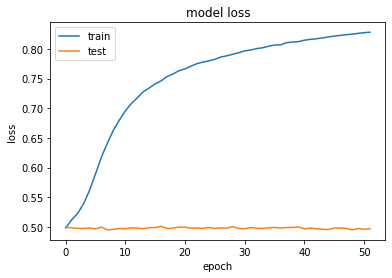

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelhist.history['acc'])
plt.plot(modelhist.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(type(x1))

<class 'numpy.ndarray'>


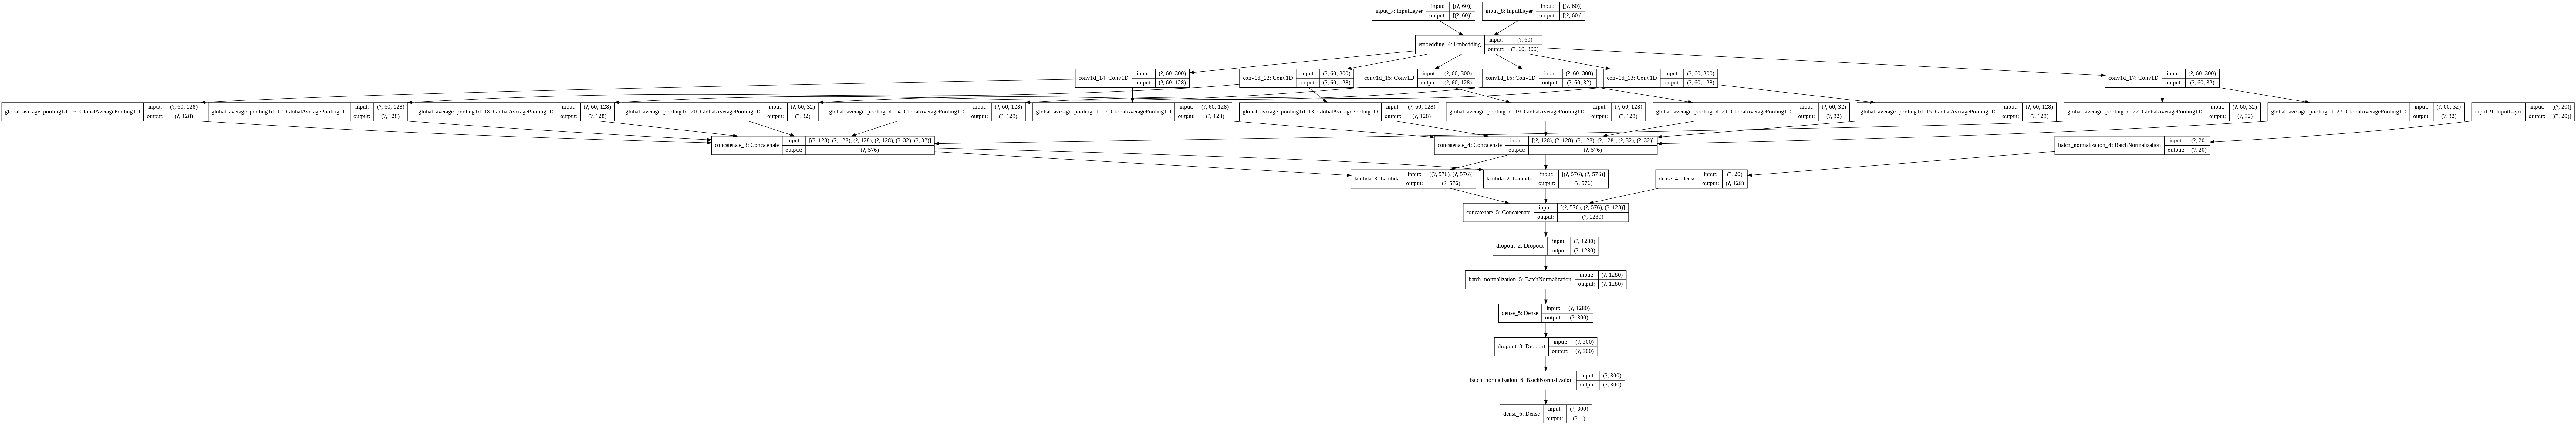

In [ ]:
plot_model(MODEL, "CONV1DMODEL.png", show_shapes=True)

Test Preprocessing
===

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
import gensim
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.parsing.preprocessing import preprocess_documents, strip_tags, strip_punctuation
stop_words = stopwords.words('english')

model = gensim.models.KeyedVectors.load_word2vec_format(googleNewsVectorsHostedPath, binary=True)
norm_model = gensim.models.KeyedVectors.load_word2vec_format(googleNewsVectorsHostedPath, binary=True)
norm_model.init_sims(replace=True)
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

def preprocess(data):
    data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['wmd'] = data.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
    data['norm_wmd'] = data.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)
    question1_vectors = np.zeros((data.shape[0], 300))
    error_count = 0
    for i, q in tqdm(enumerate(data.question1.values)):
        question1_vectors[i, :] = sent2vec(q)
    question2_vectors  = np.zeros((data.shape[0], 300))
    for i, q in tqdm(enumerate(data.question2.values)):
        question2_vectors[i, :] = sent2vec(q)
    data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]

    data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),
                                                              np.nan_to_num(question2_vectors))]
    data['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
    data['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
    data['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
    data['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]


    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]
    data['question1'] = [(remove_stopwords(" ".join(preprocess_string(x, CUSTOM_FILTERS)))) for x in data['question1'].fillna('').astype(str)]
    data['question2'] = [(remove_stopwords(" ".join(preprocess_string(x, CUSTOM_FILTERS)))) for x in data['question2'].fillna('').astype(str)]
    return data

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
chunk_size = 50000
i = 1
import time
preprocess_start_time = time.time()
df = pd.DataFrame()
for chunk in pd.read_csv(testDatasetPath, chunksize = chunk_size, index_col = 0):
  local_start_time = time.time()
  print(i)
  i+=1
  df = df.append(preprocess(chunk), ignore_index=True)
  local_end_time = time.time()
  print(local_end_time-local_start_time)
preprocess_end_time = time.time()
print("Complete time", preprocess_end_time - preprocess_start_time)
df.to_csv(testProcessedPath)

1


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
50000it [00:10, 4760.57it/s]
50000it [00:10, 4890.68it/s]
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1178: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


607.101723909378
2


50000it [00:09, 5112.58it/s]
50000it [00:10, 4905.80it/s]


607.7678916454315
3


50000it [00:09, 5122.37it/s]
50000it [00:10, 4849.14it/s]


610.5921833515167
4


50000it [00:09, 5068.64it/s]
50000it [00:10, 4748.69it/s]


616.0888981819153
5


50000it [00:09, 5165.63it/s]
50000it [00:09, 5104.87it/s]


605.4859943389893
6


50000it [00:09, 5155.25it/s]
50000it [00:09, 5131.22it/s]


608.7178170681
7


50000it [00:09, 5053.02it/s]
50000it [00:09, 5004.02it/s]


610.6370892524719
8


50000it [00:09, 5190.57it/s]
50000it [00:09, 5249.15it/s]


609.7799694538116
9


50000it [00:10, 4784.18it/s]
50000it [00:09, 5024.69it/s]


607.8200309276581
10


50000it [00:09, 5154.75it/s]
50000it [00:09, 5048.76it/s]


615.939202785492
11


50000it [00:09, 5109.74it/s]
50000it [00:09, 5095.79it/s]


608.572078704834
12


50000it [00:09, 5086.48it/s]
50000it [00:09, 5081.26it/s]


605.7901246547699
13


50000it [00:09, 5125.44it/s]
50000it [00:09, 5084.18it/s]


609.0690355300903
14


50000it [00:09, 5136.81it/s]
50000it [00:09, 5074.14it/s]


608.5483605861664
15


50000it [00:09, 5132.08it/s]
50000it [00:09, 5081.16it/s]


609.4470677375793
16


50000it [00:09, 5186.88it/s]
50000it [00:09, 5133.00it/s]


606.0082974433899
17


50000it [00:09, 5142.99it/s]
50000it [00:09, 5137.19it/s]


608.0922999382019
18


50000it [00:09, 5124.99it/s]
50000it [00:09, 5134.86it/s]


604.2003874778748
19


50000it [00:09, 5076.82it/s]
50000it [00:09, 5094.85it/s]


616.8668892383575
20


50000it [00:09, 5120.59it/s]
50000it [00:09, 5164.96it/s]


604.0966629981995
21


50000it [00:09, 5122.83it/s]
50000it [00:09, 5162.68it/s]


610.7477314472198
22


50000it [00:09, 5119.12it/s]
50000it [00:09, 5166.20it/s]


615.9626867771149
23


50000it [00:09, 5127.50it/s]
50000it [00:09, 5114.91it/s]


605.9304060935974
24


50000it [00:09, 5122.66it/s]
50000it [00:09, 5090.11it/s]


611.563467502594
25


50000it [00:09, 5147.40it/s]
50000it [00:09, 5034.84it/s]


609.7273762226105
26


50000it [00:10, 4597.76it/s]
50000it [00:10, 4703.15it/s]


609.2221989631653
27


50000it [00:09, 5052.98it/s]
50000it [00:09, 5066.53it/s]


614.7652299404144
28


50000it [00:09, 5110.16it/s]
50000it [00:09, 5170.85it/s]


607.6329469680786
29


50000it [00:09, 5118.86it/s]
50000it [00:09, 5096.23it/s]


615.7628128528595
30


50000it [00:09, 5089.48it/s]
50000it [00:09, 5042.64it/s]


607.7173407077789
31


50000it [00:09, 5007.31it/s]
50000it [00:10, 4977.12it/s]


619.3890957832336
32


50000it [00:09, 5088.77it/s]
50000it [00:09, 5135.51it/s]


614.8028335571289
33


50000it [00:09, 5026.76it/s]
50000it [00:09, 5026.11it/s]


615.5154573917389
34


50000it [00:09, 5045.84it/s]
50000it [00:09, 5053.43it/s]


619.1222279071808
35


50000it [00:09, 5083.26it/s]
50000it [00:09, 5159.08it/s]


615.0678246021271
36


50000it [00:10, 4948.51it/s]
50000it [00:09, 5138.47it/s]


605.2919075489044
37


50000it [00:09, 5131.32it/s]
50000it [00:10, 4961.40it/s]


610.7698469161987
38


50000it [00:09, 5003.53it/s]
50000it [00:09, 5086.84it/s]


606.9773461818695
39


50000it [00:09, 5148.44it/s]
50000it [00:09, 5168.38it/s]


612.7699086666107
40


50000it [00:09, 5246.17it/s]
50000it [00:09, 5186.08it/s]


599.6279003620148
41


50000it [00:09, 5073.07it/s]
50000it [00:09, 5021.23it/s]


614.0763065814972
42


50000it [00:09, 5029.63it/s]
50000it [00:09, 5110.34it/s]


610.4795813560486
43


50000it [00:09, 5099.03it/s]
50000it [00:09, 5073.68it/s]


608.590039730072
44


50000it [00:09, 5045.90it/s]
50000it [00:09, 5010.88it/s]


613.6920158863068
45


50000it [00:09, 5022.79it/s]
50000it [00:09, 5064.19it/s]


610.0740294456482
46


50000it [00:12, 3984.39it/s]
50000it [00:10, 4592.12it/s]


619.9379303455353
47


45796it [00:09, 5031.41it/s]
45796it [00:09, 5074.57it/s]


559.3894999027252
Complete time 28651.588764429092


FileNotFoundError: ignored

In [ ]:
df.to_csv(testProcessedPath)
# Complete Preprocessing Time 28651.588764429092
# Time per batch = 600 s
# numb batches = 47


# LSTM CONV DIST Model Testing

In [ ]:
def batch_pred_lstm_conv_dist(df):
  t1 = tk.texts_to_sequences(df.question1.values.astype(str))
  t1 = sequence.pad_sequences(t1, maxlen=max_len)
  t2 = tk.texts_to_sequences(df.question2.values.astype(str))
  t2 = sequence.pad_sequences(t2, maxlen=max_len)
  dist = df[distance_columns].to_numpy()
  op = [list(df['Unnamed: 0'])]
  pred = dist_lstm_conv_model.predict([t1,t2,dist])
  pred = (pred>0.5).astype(int).ravel()
  # print(type(pred))
  op.append(list(pred))
  op = np.array(op).T
  op_df = pd.DataFrame(op, columns = ['test_id', 'is_duplicate'])
  return op_df

In [ ]:
import _pickle as cPickle
dist_lstm_conv_model = main_model_dist()
checkpointlstmconvdist = ModelCheckpoint(lstmconvdistnostopwordsWeights, monitor='val_acc', save_best_only=True, verbose=2)
# early_stopping = EarlyStopping(monitor="val_loss", patience=50)
modelhistconvlstmdist = dist_lstm_conv_model.fit([x1, x2, dist], y=y_train, batch_size=3500, epochs=100, verbose=1, validation_split=0.1, shuffle=True, callbacks=[ checkpointlstmconvdist])
cPickle.dump(modelhistconvlstmdist.history,open('/content/drive/My Drive/MLPW/lstmconvdisthistnostopwords.pkl', 'wb'), -1)

Epoch 1/100
104/104 [==============================] - 148s 1s/step - loss: 0.7510 - accuracy: 0.4998 - val_loss: 0.6944 - val_accuracy: 0.5002
Epoch 2/100
104/104 [==============================] - 147s 1s/step - loss: 0.7048 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.5003
Epoch 3/100
104/104 [==============================] - 148s 1s/step - loss: 0.6996 - accuracy: 0.5016 - val_loss: 0.6934 - val_accuracy: 0.5028
Epoch 4/100
104/104 [==============================] - 148s 1s/step - loss: 0.6975 - accuracy: 0.5068 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/100
104/104 [==============================] - 148s 1s/step - loss: 0.6932 - accuracy: 0.5277 - val_loss: 0.6936 - val_accuracy: 0.4943
Epoch 6/100
104/104 [==============================] - 147s 1s/step - loss: 0.6774 - accuracy: 0.5643 - val_loss: 0.6952 - val_accuracy: 0.5020
Epoch 7/100
104/104 [==============================] - 148s 1s/step - loss: 0.6480 - accuracy: 0.5971 - val_loss: 0.7034 - val_accuracy:

In [ ]:
print(modelhistconvlstmdist.history)
import _pickle as cPickle
cPickle.dump(modelhistconvlstmdist.history,open('/content/drive/My Drive/MLPW/lstmconvdisthistnostopwords.pkl', 'wb'), -1)

{'loss': [0.7509721517562866, 0.704836905002594, 0.6996448040008545, 0.6975376009941101, 0.6932157874107361, 0.6774183511734009, 0.6480334997177124, 0.6090382933616638, 0.568878173828125, 0.5338147282600403, 0.4999098777770996, 0.47025614976882935, 0.44304898381233215, 0.4201338589191437, 0.3986377716064453, 0.37909504771232605, 0.36290398240089417, 0.3499165177345276, 0.3315291106700897, 0.3168027997016907, 0.3041525185108185, 0.29296329617500305, 0.2825242280960083, 0.27232590317726135, 0.2633300721645355, 0.2541137933731079, 0.2456693798303604, 0.23801182210445404, 0.2316906452178955, 0.2242993414402008, 0.21936491131782532, 0.21291488409042358, 0.20628269016742706, 0.20133572816848755, 0.19584417343139648, 0.19173601269721985, 0.18596504628658295, 0.18276815116405487, 0.17837871611118317, 0.1745252162218094, 0.17074909806251526, 0.16701379418373108, 0.16255135834217072, 0.16033142805099487, 0.15684184432029724, 0.15284043550491333, 0.14941535890102386, 0.14571073651313782, 0.141917

In [ ]:
dist_lstm_conv_model.save(lstmconvdistWeights)

In [ ]:
import time
test_iterator = pd.read_csv(testProcessedPath, chunksize = 50000)
i = 0
global_start_time = time.time()
time_per_chunk_lstm_conv_dist = []
submission = pd.DataFrame(columns = ['test_id','is_duplicate'])

for chunk in test_iterator:
    i = i+1
    loop_start_time = time.time()
    dfapp = batch_pred_lstm_conv_dist(chunk)
    loop_time = loop_start_time-time.time()
    time_per_chunk_lstm_conv_dist.append(loop_time)
    print("chunk ",i," execution_time ",loop_time, sep= '')
    submission = submission.append(dfapp)
global_train_time = global_start_time - time.time()
print("total train time ", global_train_time, sep = '')
submission.to_csv(lstmconvdistPreds)

chunk 1 execution_time -66.00583839416504
chunk 2 execution_time -58.12378931045532
chunk 3 execution_time -58.19488835334778
chunk 4 execution_time -58.40837073326111
chunk 5 execution_time -58.54609298706055
chunk 6 execution_time -58.94350624084473
chunk 7 execution_time -58.41986155509949
chunk 8 execution_time -58.84082555770874
chunk 9 execution_time -58.38354015350342
chunk 10 execution_time -58.58059787750244
chunk 11 execution_time -58.55524206161499
chunk 12 execution_time -58.849451780319214
chunk 13 execution_time -58.28356313705444
chunk 14 execution_time -58.495144844055176
chunk 15 execution_time -57.829426288604736
chunk 16 execution_time -58.490638256073
chunk 17 execution_time -58.717578172683716
chunk 18 execution_time -58.08637261390686
chunk 19 execution_time -58.35219669342041
chunk 20 execution_time -58.64433741569519
chunk 21 execution_time -58.342267751693726
chunk 22 execution_time -59.399564027786255
chunk 23 execution_time -58.55656099319458
chunk 24 executi

In [ ]:
submission.to_csv(lstmconvdistPreds, index = False)

In [ ]:

submission = pd.read_csv(lstmconvdistPreds)

In [ ]:
submission.head()

,test_id,is_duplicate
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [ ]:
submission.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
submission.to_csv(lstmconvdistPreds, index = False)

In [ ]:
submission.shape

(2345796, 2)

In [ ]:
submission['test_id'] = submission.index